In [1]:
import re
import os
import sys
import datetime
import itertools
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.tsa.api as smt

from matplotlib.pylab import rcParams
plt.rcParams['savefig.dpi'] = 250
plt.rcParams['figure.figsize'] = (18, 5)
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"

pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)

import warnings
warnings.filterwarnings('ignore')

from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.formula.api as smf
import statsmodels.api as sm

import scipy.stats as scs
from ipywidgets import interactive, widgets, RadioButtons, ToggleButtons, Select, FloatSlider, FloatProgress
from IPython.display import set_matplotlib_formats, Image
from datetime import datetime

from math import sqrt
from sklearn.metrics import mean_squared_error

from ipywidgets import interactive, widgets, RadioButtons, ToggleButtons, Select, FloatSlider, FloatProgress
from IPython.display import set_matplotlib_formats, Image

from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize 
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error

### Visualizar la demanda como serie de tiempo

In [4]:
#serie de tiempo en grafico
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

#leer la data del excel de los huespedes.csv
demand_data = pd.read_csv('./data/DemandaInfo.csv', parse_dates=['time'], index_col='time',date_parser=dateparse)

#guardar en otra variable
demand_ts = demand_data['demand']

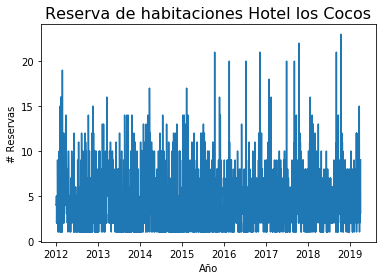

In [5]:
#imprimir la serie de tiempo
plt.plot(demand_ts, linewidth=1.5)
plt.title(u'Reserva de habitaciones Hotel los Cocos', fontsize=16)
plt.ylabel(u'# Reservas')
plt.xlabel(u'Año')
plt.show()

In [6]:
#agrupamos los dias por meses
demand_ts  = demand_data['demand'].resample('MS').sum()

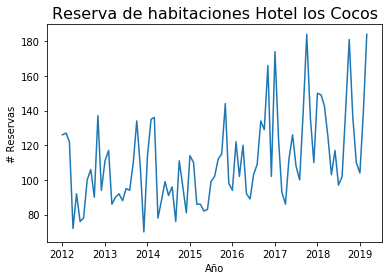

In [8]:
#imprimir la serie de tiempo
plt.plot(demand_ts, linewidth=1.5)
plt.title(u'Reserva de habitaciones Hotel los Cocos', fontsize=16)
plt.ylabel(u'# Reservas')
plt.xlabel(u'Año')
plt.show()

In [9]:
#Dividir datos de prueba y entrenamiento
y_train = demand_ts[:'2018']
y_test = demand_ts['2019':]

print(len(y_train))
print(len(y_test))

84
3


In [10]:
#Mostrar datos

model = ExponentialSmoothing(y_train, seasonal='add', seasonal_periods=12).fit()
pred = model.predict(start=2204, end=2295)

#Volver entero predicho y muestra de informacion
prediction = list(map(lambda x: int(x), pred))
print(y_test)
print(prediction)

time
2019-01-01    104
2019-02-01    141
2019-03-01    184
Freq: MS, Name: demand, dtype: int64
[134, 151, 148, 111, 145, 145, 128, 112, 112, 115, 113, 118, 134, 151, 148, 111, 145, 145, 128, 112, 112, 115, 113, 118, 134, 151, 148, 111, 145, 145, 128, 112, 112, 115, 113, 118, 134, 151, 148, 111, 145, 145, 128, 112, 112, 115, 113, 118, 134, 151, 148, 111, 145, 145, 128, 112, 112, 115, 113, 118, 134, 151, 148, 111, 145, 145, 128, 112, 112, 115, 113, 118, 134, 151, 148, 111, 145, 145, 128, 112, 112, 115, 113, 118, 134, 151, 148, 111, 145, 145, 128, 112]


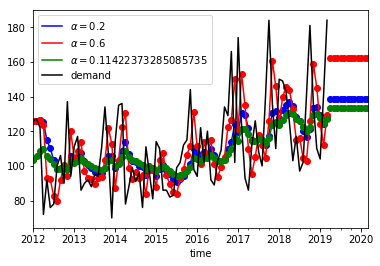

In [11]:
# Simple Exponential Smoothing
fit1 = SimpleExpSmoothing(demand_ts).fit(smoothing_level=0.2,optimized=False)
fcast1 = fit1.forecast(12).rename(r'$\alpha=0.2$')
# plot
fcast1.plot(marker='o', color='blue', legend=True)
fit1.fittedvalues.plot(marker='o',  color='blue')



fit2 = SimpleExpSmoothing(demand_ts).fit(smoothing_level=0.6,optimized=False)
fcast2 = fit2.forecast(12).rename(r'$\alpha=0.6$')
# plot
fcast2.plot(marker='o', color='red', legend=True)
fit2.fittedvalues.plot(marker='o', color='red')


fit3 = SimpleExpSmoothing(demand_ts).fit()
fcast3 = fit3.forecast(12).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])
# plot
fcast3.plot(marker='o', color='green', legend=True)
fit3.fittedvalues.plot(marker='o', color='green')
demand_ts.plot(color='black', legend=True)

plt.show()

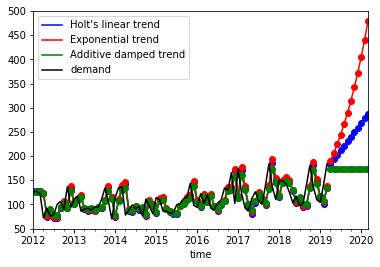

In [12]:
fit1 = Holt(demand_ts).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast1 = fit1.forecast(12).rename("Holt's linear trend")

fit2 = Holt(demand_ts, exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast2 = fit2.forecast(12).rename("Exponential trend")

fit3 = Holt(demand_ts, damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
fcast3 = fit3.forecast(12).rename("Additive damped trend")


fit1.fittedvalues.plot(marker="o", color='blue')
fcast1.plot(color='blue', marker="o", legend=True)

fit2.fittedvalues.plot(marker="o", color='red')
fcast2.plot(color='red', marker="o", legend=True)

fit3.fittedvalues.plot(marker="o", color='green')
fcast3.plot(color='green', marker="o", legend=True)

demand_ts.plot(color='black', legend=True)

plt.show()

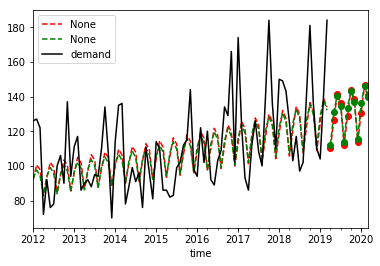

Forecasting sales of properties using Holt-Winters method with both additive and multiplicative seasonality.


In [13]:
fit1 = ExponentialSmoothing(demand_ts, seasonal_periods=4, trend='add', seasonal='add').fit(use_boxcox=True)
fit2 = ExponentialSmoothing(demand_ts, seasonal_periods=4, trend='add', seasonal='mul').fit(use_boxcox=True)
fit3 = ExponentialSmoothing(demand_ts, seasonal_periods=4, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
fit4 = ExponentialSmoothing(demand_ts, seasonal_periods=4, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
fit1.fittedvalues.plot(style='--', color='red')
fit2.fittedvalues.plot(style='--', color='green')

fit1.forecast(12).plot(style='--', marker='o', color='red', legend=True)
fit2.forecast(12).plot(style='--', marker='o', color='green', legend=True)
demand_ts.plot(color='black', legend=True)

plt.show()
print("Forecasting sales of properties using Holt-Winters method with both additive and multiplicative seasonality.")

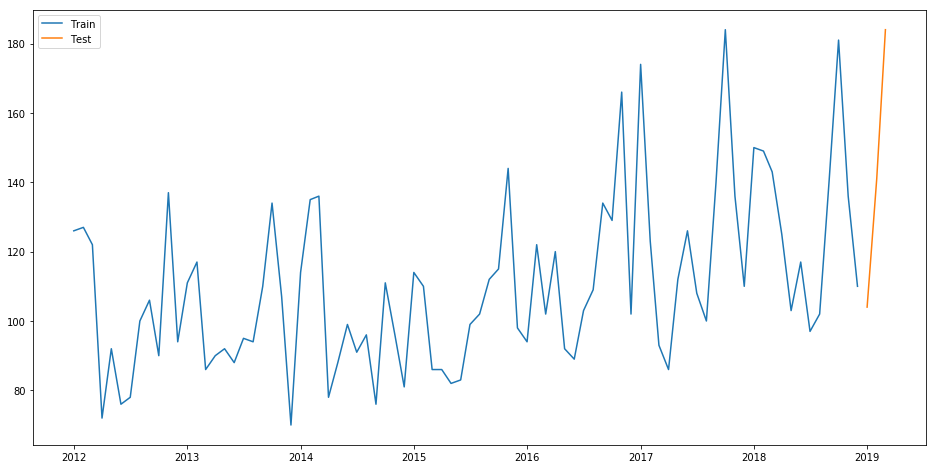

104
141
184
[145.89493 145.59158 128.86757]


In [26]:
y_hat_avg = y_test.copy()
fit1 = ExponentialSmoothing(np.asarray(y_train) ,seasonal_periods=12, seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(y_test))
plt.figure(figsize=(16,8))
plt.plot( y_train, label='Train')
plt.plot(y_test, label='Test')
#plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

print(y_hat_avg.values[0])
print(y_hat_avg.values[1])
print(y_hat_avg.values[2])
print(y_hat_avg.values[3])

In [33]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
  
    acf1 = acf([ y_hat_avg.values[0], y_hat_avg.values[1], y_hat_avg.values[2] ])[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr})
forecast_accuracy(y_hat_avg.values[3], [ y_hat_avg.values[0], y_hat_avg.values[1], y_hat_avg.values[2] ])

{'acf1': -0.0012476606363069243,
 'corr': -0.8939298194326843,
 'mae': 33.87298056765757,
 'mape': 0.24501101513103554,
 'me': -2.8819732970907714,
 'mpe': 0.045255831083490204,
 'rmse': 40.06599851435131}